# Libraries

In [171]:
# import csv
# import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [172]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample()

,title,url,year,text,tags,GPE,IND,ORG
48,Rod Rosenstein Expected to Leave Justice Dept....,https://www.nytimes.com/2019/01/09/us/politics...,2019,"Supported by\nRod Rosenstein, a Tough-on-Crime...","[{'label': 'politics and government', 'score':...","[WASHINGTON, Russia, the United States’, Russi...","[Rod Rosenstein, Rod J. Rosenstein, Trump, Tru...","[Maelstrom, the Justice Department, F.B.I., th..."


## Cleaning

In [173]:
df = df[df['url'].apply(lambda x: 'www.nytimes.com/live/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/briefing/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/topic/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcast/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcasts/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/dealbook/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/world/iraq-war-logs' not in x)]
df = df.reset_index(drop=True)

df['url'] = df['url'].apply(lambda x: x.split('?', 1)[0]) # delete multiple URLs
df = df.drop_duplicates(subset='url', keep="first")
df = df.reset_index(drop=True)


In [174]:
df.sample()

,title,url,year,text,tags,GPE,IND,ORG
1742,Commerce Secretary Gina Raimondo to Visit Chin...,https://www.nytimes.com/2023/08/22/business/ec...,2023,Supported by\nCommerce Secretary to Visit Chin...,[{'label': 'international trade and world mark...,"[U.S.-China, Washington, Beijing, Shanghai, Ch...","[Gina Raimondo, Gina Raimondo, Biden, Raimondo...","[Commerce, commerce, commerce, the Department ..."


## Cleaning

In [175]:
total = 0

for index, row in df.iterrows():

    # print(row)
           
    gpe = list(row["GPE"])
    ind = list(row["IND"])
    org = list(row["ORG"])
    
    
    # gpe

    if 'Trump' in gpe: gpe.remove('Trump')

    gpe = list(map(lambda x: x.replace(".", ""), gpe))
    gpe = list(map(lambda x: x.replace("’s", ""), gpe))
    gpe = list(map(lambda x: x.replace("The ", ""), gpe))
    gpe = list(map(lambda x: x.replace("the ", ""), gpe))
    
    gpe = ['California' if 'Calif' in x else x for x in gpe]
    gpe = ['Florida' if 'Fla' in x else x for x in gpe]
    gpe = ['New York' if 'NY' in x else x for x in gpe]
    gpe = ['New Jersey' if 'NJ' in x else x for x in gpe]
    gpe = ['Washington' if 'WASHINGTON' in x else x for x in gpe]
    gpe = ['Baghdad' if 'BAGHDAD' in x else x for x in gpe]
    gpe = ['United States' if 'US' in x else x for x in gpe]
    gpe = ['Massachusetts' if 'Mass' in x else x for x in gpe]
    gpe = ['Virginia' if 'Va' in x else x for x in gpe]
    gpe = ['District of Columbia' if 'DC' in x else x for x in gpe]


    # individuals

    ind = list(map(lambda x: x.replace(".", ""), ind)) # remove dots
    ind = list(map(lambda x: re.sub(' [A-Z]* ', ' ', x), ind)) # remove middle initial
    
    ind = [a for a in ind if (" " in a)]  # remove ind without space
    ind = [a for a in ind if ("\n" not in a)]  # remove ind with \n

    ind = ['Bill De Blasio' if 'De Blasio' in x else x for x in ind]
    ind = ['Bill De Blasio' if 'de Blasio' in x else x for x in ind]
    ind = ['Carlos De Oliveira' if 'De Oliveira' in x else x for x in ind]

    ind = ['Mohammed bin Salman' if 'Crown Prince Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Crown Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Prince Mohammed' in x else x for x in ind]

    ind = ['Paul Mozur' if 'paul mozur' in x else x for x in ind]
    ind = ['Jane Coaston' if 'jane coaston' in x else x for x in ind]
    ind = ['Michael Barbaro' if 'michael barbaro' in x else x for x in ind]
    ind = ['Osama bin Laden' if 'Bin Laden' in x else x for x in ind]
    ind = ['Osama bin Laden' if 'Osama Bin Laden' in x else x for x in ind]
    ind = ['Carlos Ghosn' if 'carlos ghosn' in x else x for x in ind]
    
    
    # org

    if 'State' in org: org.remove('State')
    if 'New York Times Opinion' in org: org.remove('New York Times Opinion')
    if 'New York Times Opinion Section on' in org: org.remove('New York Times Opinion Section on')
    if 'Parliament' in org: org.remove('Parliament')

    org = list(map(lambda x: x.replace(".", ""), org))
    org = list(map(lambda x: x.replace("’s", ""), org))
    org = list(map(lambda x: x.replace("The ", ""), org))
    org = list(map(lambda x: x.replace("the ", ""), org))

    org = ['United States' if 'US' in x else x for x in org]
    org = ['United Nations' if 'UN' in x else x for x in org]
    org = ['United Nations' if 'un' in x else x for x in org]
    org = ['World Health Organization' if 'WHO' in x else x for x in org]
    org = ['National Security Agency' if 'NSA' in x else x for x in org]
    org = ['Food and Drugs Administration' if 'FDA' in x else x for x in org]
    org = ['NSO Group' if 'NSO' in x else x for x in org]
    org = ['Al Qaeda' if 'Qaeda' in x else x for x in org]
    org = ['Centers for Disease Control and Prevention' if 'CDC' in x else x for x in org]
    org = ['Immigration and Customs Enforcement' if 'ICE' in x else x for x in org]
    org = ['Fox News' if 'Fox' in x else x for x in org]
    org = ['New York Times' if 'Times' in x else x for x in org]
    org = ['Alternative for Germany' if 'AfD' in x else x for x in org]
    org = ['Drug Enforcement Administration' if 'DEA' in x else x for x in org]
    org = ['Central Intelligence Agency' if 'CIA' in x else x for x in org]
    org = ['Federal Bureau of Investigation' if 'FBI' in x else x for x in org]


    # save

    df.loc[index, "GPE"] = gpe
    df.loc[index, "IND"] = ind
    df.loc[index, "ORG"] = org


    # total

    total += len(gpe) + len (ind) + len(org)

total

160513

## Set tags

In [176]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        if i < 3:
            tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

df.sample()

,title,url,year,text,GPE,IND,ORG,TAG
2134,"Teenager Set Manhattan Synagogue Ablaze, Polic...",https://www.nytimes.com/2017/05/17/nyregion/te...,2017,Supported by\nTeenager Set Manhattan Synagogue...,"[Manhattan Synagogue, Manhattan, Manhattan, Li...","[Beth Hamedrash Hagodol, Robert Boyce, James O...","[Riverside Church, Great House of Study, Famil...","[synagogues, fires and firefighters, religion ..."


## Clean Years

In [177]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2020', '2021', '2022', '2018', '2017', '2013', '2011', '2023', '2016', '2015', '2012', '2019', '2014', '2010'}


## Entities

In [178]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    tag = row["TAG"]
    
    cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 33497


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
3,United States,gpe,7261,NaN,None,-1,-1,-1,"{'2010': 82, '2011': 87, '2012': 90, '2013': 4...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ..."


# Treatment

## Normalization

In [179]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
32592,Matt Pittinsky,ind,1,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 1, '2013': 0, '...",[https://www.nytimes.com/2012/07/22/education/...,[Colleges Awakening to the Opportunities of Da...,"[Tempe, Milwaukee, Arizona, Tennessee, Arizona...",0.0,"{""2010"": 0, ""2011"": 0, ""2012"": 1, ""2013"": 0, ""..."


## Filter

In [232]:
# Number of rows by type

max_gpe = 40
max_ind = 80
max_org = 40
max_tag = 80

# min_frequency = 50

top_gpe = (
    entities_all.loc[
        (entities_all["type"] == "gpe")
        # & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_gpe)
)
top_ind = (
    entities_all.loc[
        (entities_all["type"] == "ind")
        # & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_ind)
)
top_org = (
    entities_all.loc[
        (entities_all["type"] == "org")
        # & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_org)
)
top_tag = (
    entities_all.loc[
        (entities_all["type"] == "tag")
        # & (entities_all["frequency"] > 10)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_tag)
)

entities = pd.concat([top_gpe, top_ind, top_org, top_tag])

len(entities)

240

In [233]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3,United States,gpe,7261,NaN,None,-1,-1,-1,"{'2010': 82, '2011': 87, '2012': 90, '2013': 4...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ...",1.000000,"{""2010"": 82, ""2011"": 87, ""2012"": 90, ""2013"": 4..."
0,China,gpe,5470,NaN,None,-1,-1,-1,"{'2010': 45, '2011': 4, '2012': 58, '2013': 10...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ...",0.753306,"{""2010"": 45, ""2011"": 4, ""2012"": 58, ""2013"": 10..."
826,Russia,gpe,2383,NaN,None,-1,-1,-1,"{'2010': 12, '2011': 4, '2012': 4, '2013': 79,...",[https://www.nytimes.com/2018/12/28/us/politic...,[Departing House Republicans Try to Keep Inves...,"[Washington, Virginia, South Carolina, Russia,...",0.328099,"{""2010"": 12, ""2011"": 4, ""2012"": 4, ""2013"": 79,..."


## Linear Regression

In [234]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2233,Adam Satariano,ind,42,0.13783,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/02/26/technology...,[U.A.E. to Use Equipment From Huawei Despite A...,"[Spain, United Arab Emirates, United States, U...",0.005647,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Colors

In [235]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3,United States,gpe,7261,90.932637,#b40426,-1,-1,-1,"{'2010': 82, '2011': 87, '2012': 90, '2013': 4...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ...",1.0,"{""2010"": 82, ""2011"": 87, ""2012"": 90, ""2013"": 4..."


# Embedding

## Term Frequency

In [236]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

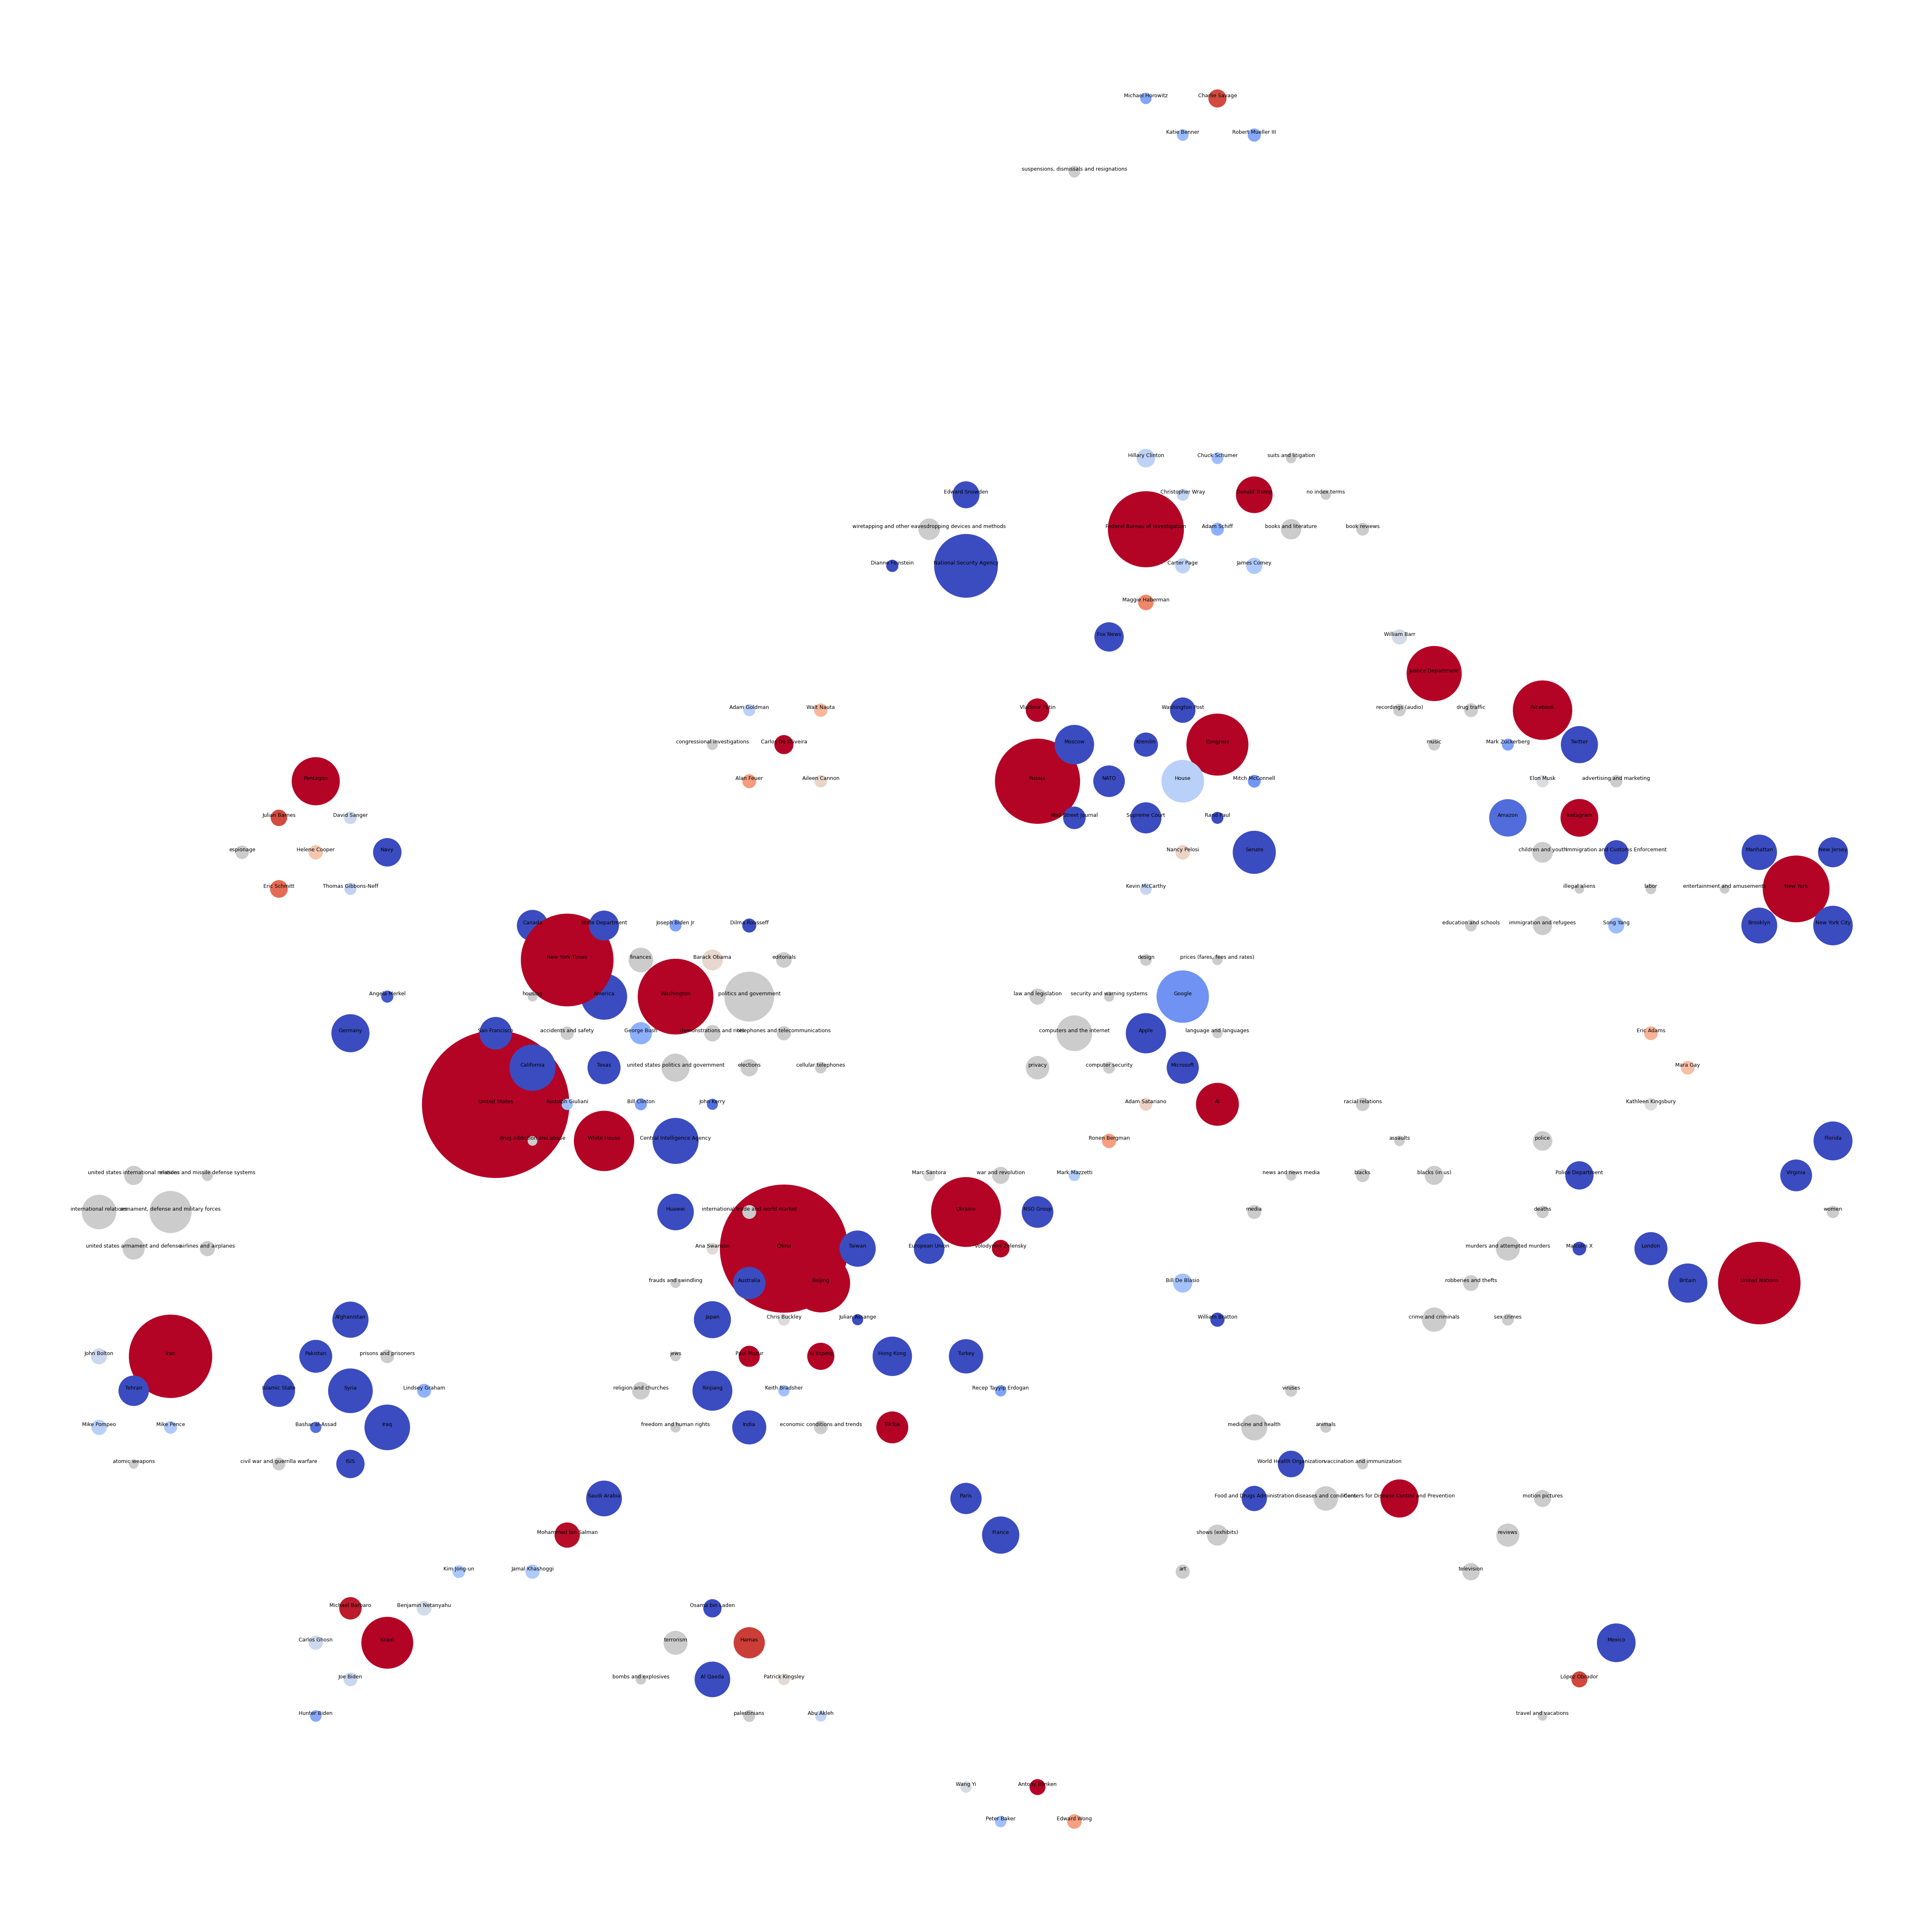

In [253]:
reducer = umap.UMAP(
    random_state=5,
    n_components=2,
    n_neighbors=2,
    min_dist=0.3,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [254]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2244,Kim Jong-un,ind,41,-0.334698,#aac7fd,266,216,-1,"{'2010': 0, '2011': 2, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/02/27/world/asia...,"[Intelligent, Bright and Merciless: A North Ko...","[SEOUL, South Korea, North Korea, Denmark, Swe...",0.00551,"{""2010"": 0, ""2011"": 2, ""2012"": 0, ""2013"": 0, ""..."


{'p_4', 'n_12', 'p_8', 'n_2', 'p_3', 'n_11', '-1', 'n_1', 'n_8', 'n_13', 'n_7', 'n_6', 'n_0', 'p_6', 'n_9', 'n_14', 'p_2', 'p_7', 'n_4', 'p_0', 'p_1', 'n_5', 'n_10', 'p_5', 'n_3'}
4
41
7
7
4
3
45
4
11
3
19
5
4
6
10
4
8
6
5
6
4
10
3
10
11


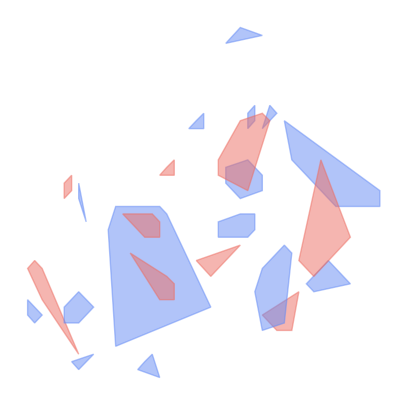

In [255]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [256]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
2380,Eric Schmitt,ind,88,0.696071,#e36c55,183,533,p_1,[https://www.nytimes.com/2019/03/02/world/afri...,0.011983,"{""2010"": 0, ""2011"": 3, ""2012"": 0, ""2013"": 2, ""..."
